## **Step 1: Importing Libraries**

The code starts by importing essential libraries for working with PyTorch, data handling, and using Vision Transformers (ViT) from Hugging Face's Transformers library.
## **Step 2: Define Dataset Paths**

`data_dir` is set to the directory path containing the dataset. This is where the dataset is located in Kaggle's environment.
## **Step 3: Define Data Transformations**

**Two sets of data transformations are defined:**
**train_transform:** A series of data augmentation techniques for the training data, including random resized cropping, horizontal flipping, random rotation, color jitter, tensor conversion, and normalization.
**val_test_transform:** Transformations for validation and test data, including resizing, tensor conversion, and normalization.

## **Step 4: Create Datasets and Data Loaders**

* Three datasets (train_dataset, valid_dataset, and test_dataset) are created using the specified transformations and dataset paths.
* Data loaders (train_loader, valid_loader, and test_loader) are set up to load data in batches for training, validation, and testing.

## **Step 5: Load Pre-trained ViT Model**

* The code loads a pre-trained Vision Transformer (ViT) model named "google/vit-base-patch16-224-in21k" from the Hugging Face model hub.
* It also initializes a feature extractor and the classification head of the ViT model for image classification with the number of classes from the training dataset.

## **Step 6: Define Loss Function and Optimizer**

* The loss function (criterion) is set to Cross-Entropy Loss.
* The optimizer (optimizer) is set to AdamW with a learning rate of 0.0001. You can adjust this learning rate as needed.

## **Step 7: Learning Rate Scheduler**

A learning rate scheduler (scheduler) is defined using the OneCycleLR scheduler. It is used to adjust the learning rate during training with a maximum learning rate of 0.001 over a specified number of steps.
## **Step 8: Training Loop**

* The code enters a training loop that runs for a specified number of epochs (20 in this case).
* It moves the model to the GPU if available (uses CUDA), as specified by device.
* Inside the loop, it iterates over the training data in batches and performs the following steps:
1. Loads data to the GPU.
2. Computes model predictions (outputs) and calculates the loss.
3. Backpropagates the loss and updates model weights using the optimizer.
4. Keeps track of the running loss.
* After each epoch, it evaluates the model on the validation dataset and computes the validation accuracy.
* It saves the model with the best validation accuracy to a file named "best_model.pth."
* The training progress, including loss and validation accuracy, is printed to the console.
* The learning rate is adjusted using the scheduler.

## **Step 9: Load the Best Model for Testing**

* After training, it loads the best-performing model (based on validation accuracy) from the saved checkpoint file "best_model.pth."

## **Step 10: Testing the Model**

* The model is set to evaluation mode (model.eval()).
* It iterates through the test data, makes predictions, and calculates the test accuracy.
* The final test accuracy is printed to the console.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from transformers import ViTFeatureExtractor, ViTForImageClassification
import imgaug.augmenters as iaa
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


seq =iaa.Sequential([
        iaa.pillike.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),
        iaa.Rotate((-20, 20)),#rotation_range
        iaa.Flipud(0.5),
        iaa.ShearX((-72, 72)),#shear_range
        iaa.Affine(translate_percent={"x": (-0.2, 0.2)}, cval=(0, 255)),#width_shift_range
        iaa.Affine(translate_percent={"y": (-0.2, 0.2)}, cval=(0, 255)),#height_shift_range
    ])

tfs = transforms.Compose([
    transforms.RandomResizedCrop(224),
    np.asarray,
    seq.augment_image,
    np.copy,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),#preprocess_input
])



val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define dataset paths
data_dir = "/home/dip_3/MasterFolder/SplitData"
# Create datasets and data loaders
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "Train"), transform=tfs)
valid_dataset = datasets.ImageFolder(os.path.join(data_dir, "Valid"), transform=val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "Test"), transform=val_test_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
print(train_loader,valid_loader,test_loader)
# Load the pre-trained ViT model
model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor(model_name)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(train_dataset.classes))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00005)  # Adjust learning rate

# Learning rate scheduler with warm-up
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=len(train_loader) * 20)

# Training loop
num_epochs = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_validation_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print(f"Starting epoch {epoch + 1}/{num_epochs}")
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Validation loop
    model.eval()
    with torch.no_grad():

        correct = 0
        total = 0
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        validation_accuracy = 100 * correct / total
        
        # Save the model if validation accuracy improved
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            torch.save(model.state_dict(), "best_model.pth")
    
    print(f"Epoch [{epoch + 1}/{num_epochs}] "
          f"Loss: {running_loss / len(train_loader):.4f} "
          f"Validation Accuracy: {validation_accuracy:.2f}%")
    
    # Adjust learning rate
    scheduler.step()



# Testing the model
model.eval()
test_correct = 0
test_total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate precision, recall, and F1-score
class_names = train_dataset.classes
classification_rep = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)

for class_name in class_names:
    precision = classification_rep[class_name]["precision"]
    recall = classification_rep[class_name]["recall"]
    f1_score = classification_rep[class_name]["f1-score"]
    
    print(f"Class: {class_name}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1_score:.2f}")
    print()

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


<torch.utils.data.dataloader.DataLoader object at 0x7fa681242cd0> <torch.utils.data.dataloader.DataLoader object at 0x7fa68191a510> <torch.utils.data.dataloader.DataLoader object at 0x7fa681620b50>


/home/dip_3/miniconda3/envs/pt/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting epoch 1/40


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Url:  https://media.wired.co.uk/photos/60c8730fa81eb7f50b44037e/16:9/w_2560%2Cc_limit/1521-WIRED-Cat.jpeg


Predicted Class: Angry, Confidence: 85.64%


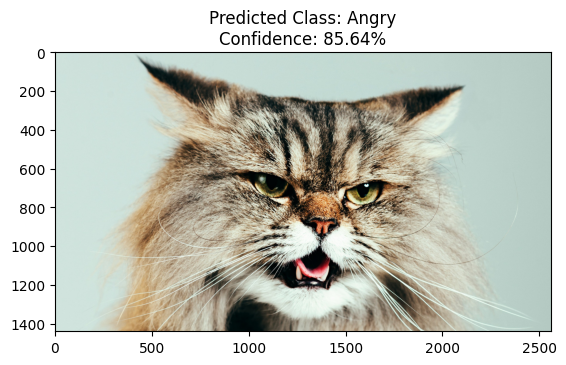

In [31]:
import torch
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torchvision import transforms
from PIL import Image
import requests
import matplotlib.pyplot as plt

model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor(model_name)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the trained model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()  # Set the model to evaluation mode

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess an example image
url = input("Url: ")
image = Image.open(requests.get(url, stream=True).raw)
original_image = image.copy()

# Apply transformations
image = val_test_transform(image)
image = image.unsqueeze(0)  # Add a batch dimension (since the model expects batch input)

# Create a list of class labels
class_labels = ['Angry', 'Happy', 'Other', 'Sad']  

with torch.no_grad():
    image = image.to(device)  # Move the input image to the appropriate device (e.g., GPU)
    outputs = model(image)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
    confidence, predicted = torch.max(probabilities, 1)  # Get the class with the highest probability
    predicted_class = class_labels[predicted.item()]  # Map the predicted index to a class label
    confidence_percentage = confidence.item() * 100  # Convert confidence to percentage

# Print the predicted class and confidence
print(f"Predicted Class: {predicted_class}, Confidence: {confidence_percentage:.2f}%")

# Display the image with predicted class and confidence
plt.imshow(original_image)
plt.title(f"Predicted Class: {predicted_class}\nConfidence: {confidence_percentage:.2f}%")
plt.show()
